**IMPORT ALL THE LIBRARIES**

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression


**MOUNT ALL THE FILES FROM DRIVE**







In [33]:
df1 = pd.read_csv('/content/drive/MyDrive/Data Science/UNSW_2018_IoT_Botnet_Full5pc_1.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Data Science/UNSW_2018_IoT_Botnet_Full5pc_2.csv')
df3 = pd.read_csv('/content/drive/MyDrive/Data Science/UNSW_2018_IoT_Botnet_Full5pc_3.csv')
df4 = pd.read_csv('/content/drive/MyDrive/Data Science/UNSW_2018_IoT_Botnet_Full5pc_4.csv')

<ipython-input-33-5cab62491cfc>:1: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('/content/drive/MyDrive/Data Science/UNSW_2018_IoT_Botnet_Full5pc_1.csv')
<ipython-input-33-5cab62491cfc>:2: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('/content/drive/MyDrive/Data Science/UNSW_2018_IoT_Botnet_Full5pc_2.csv')
<ipython-input-33-5cab62491cfc>:3: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv('/content/drive/MyDrive/Data Science/UNSW_2018_IoT_Botnet_Full5pc_3.csv')
<ipython-input-33-5cab62491cfc>:4: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df4 = pd.read_csv('/content/drive/MyDrive/Data Science/UNSW_2018_IoT_Botnet_Full5pc_4.csv')


**CONCATENATE ALL FILES INTO A SINGLE DATAFRAME**

In [34]:
df = pd.concat([df1, df2, df3, df4], ignore_index=True)



**ANALYSIS**

you get to know that some features are to be removed straight away as the dont have any relation with the target variable which is attack or category/subcategory according to what type of classification is to be performed (binary/multi-class classification) following are the features that should be removed straight away and also reasons to why they should be removed.

**FEATURES TO BE REMOVED**

*   **pkSeqID** - Just a row ID — no info about the network behavior.
*   **saddr, daddr** - IPs are high-cardinality and often act like IDs (no generalization).
*   **seq, ack** - TCP sequence numbers — random, not helpful for ML unless deep packet inspection is done.
*   **ct_state_ttl, ct_flw_http_mthd, is_sm_ips_ports** - Often constant or nearly 0 so in Bot-IoT (check nunique() to confirm).
*   **flgs** - Often low variance, can be ignored if not meaningful after inspection.



In [35]:
features_to_drop = ['pkSeqID','saddr', 'daddr','stime', 'ltime','flgs','flgs_number', 'seq', 'sport', 'dport', 'proto', 'proto_number', 'state', 'state_number','category','subcategory']


features_to_drop = [feature for feature in features_to_drop if feature in df.columns]

df = df.drop(columns=features_to_drop)
df.head()



,pkts,bytes,dur,mean,stddev,sum,min,max,spkts,dpkts,...,TnP_Per_Dport,AR_P_Proto_P_SrcIP,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack
0,8,1980,7.056393,0.068909,0.068909,0.137818,0.000000,0.137818,5,3,...,772,1.142970,1.12704,96,75,1.133720,1.129970,770,602,1
1,2,120,0.000131,0.000131,0.000000,0.000131,0.000131,0.000131,1,1,...,8,0.003857,15267.20000,1,2,0.005142,0.005142,2,6,1
2,8,2126,7.047852,0.064494,0.064494,0.128988,0.000000,0.128988,5,3,...,772,1.142970,1.12704,96,75,1.135100,1.129970,770,602,1
3,8,2024,7.047592,0.064189,0.064189,0.128378,0.000000,0.128378,5,3,...,772,1.142970,1.12704,96,75,1.135140,1.129970,770,602,1
4,8,2319,7.046841,0.063887,0.063887,0.127774,0.000000,0.127774,5,3,...,772,1.142970,1.12704,96,75,1.135260,1.129970,770,602,1


**SELECTING THE ROWS**

let's just shuffle the dataset and keep only around 1 lakh rows so that we get enough from all four files and there would be not much load on computer

In [36]:
df = df.sample(n=150000).reset_index(drop=True)
df

,pkts,bytes,dur,mean,stddev,sum,min,max,spkts,dpkts,...,TnP_Per_Dport,AR_P_Proto_P_SrcIP,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack
0,4,616,24.265186,0.000000,0.000000,0.000000,0.000000,0.000000,4,0,...,400,0.164845,0.164845,100,100,0.164845,0.164845,400,400,1
1,1,154,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,...,108,0.000000,73.651100,100,96,0.000000,73.651100,96,96,1
2,7,420,29.719324,1.489311,1.824641,7.446553,0.000000,3.798186,7,0,...,781,0.235506,0.235506,91,91,0.235537,0.260566,637,637,1
3,8,480,24.981991,3.554996,0.026409,14.219985,3.518597,3.584869,8,0,...,762,0.320275,0.320275,81,81,0.320231,0.315732,648,648,1
4,4,616,58.687523,0.000000,0.000000,0.000000,0.000000,0.000000,4,0,...,457,0.077807,0.077807,100,100,0.068158,0.077807,172,172,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,7,420,12.161448,2.706286,1.913634,8.118858,0.000000,4.062305,7,0,...,700,0.575589,0.575589,100,100,0.575589,0.575589,700,700,1
149996,11,660,24.610233,2.846478,0.532189,14.232388,2.539589,3.909683,11,0,...,1100,0.446975,0.446975,100,100,0.446969,0.446975,1100,1100,1
149997,3,274,0.178547,0.178547,0.000000,0.178547,0.178547,0.178547,2,1,...,300,15.937700,15.937700,100,100,16.802300,15.937700,300,300,1
149998,8,480,32.158215,3.298694,0.798594,13.194777,1.935859,3.975932,8,0,...,800,0.248772,0.248772,100,100,0.248770,0.248772,800,800,1


**CHECK FOR NULL OR NAN VALUES**

In [37]:
df.isnull().sum()
df.isna().sum()

,0
pkts,0
bytes,0
dur,0
mean,0
stddev,0
sum,0
min,0
max,0
spkts,0
dpkts,0


**HISTOGRAM**

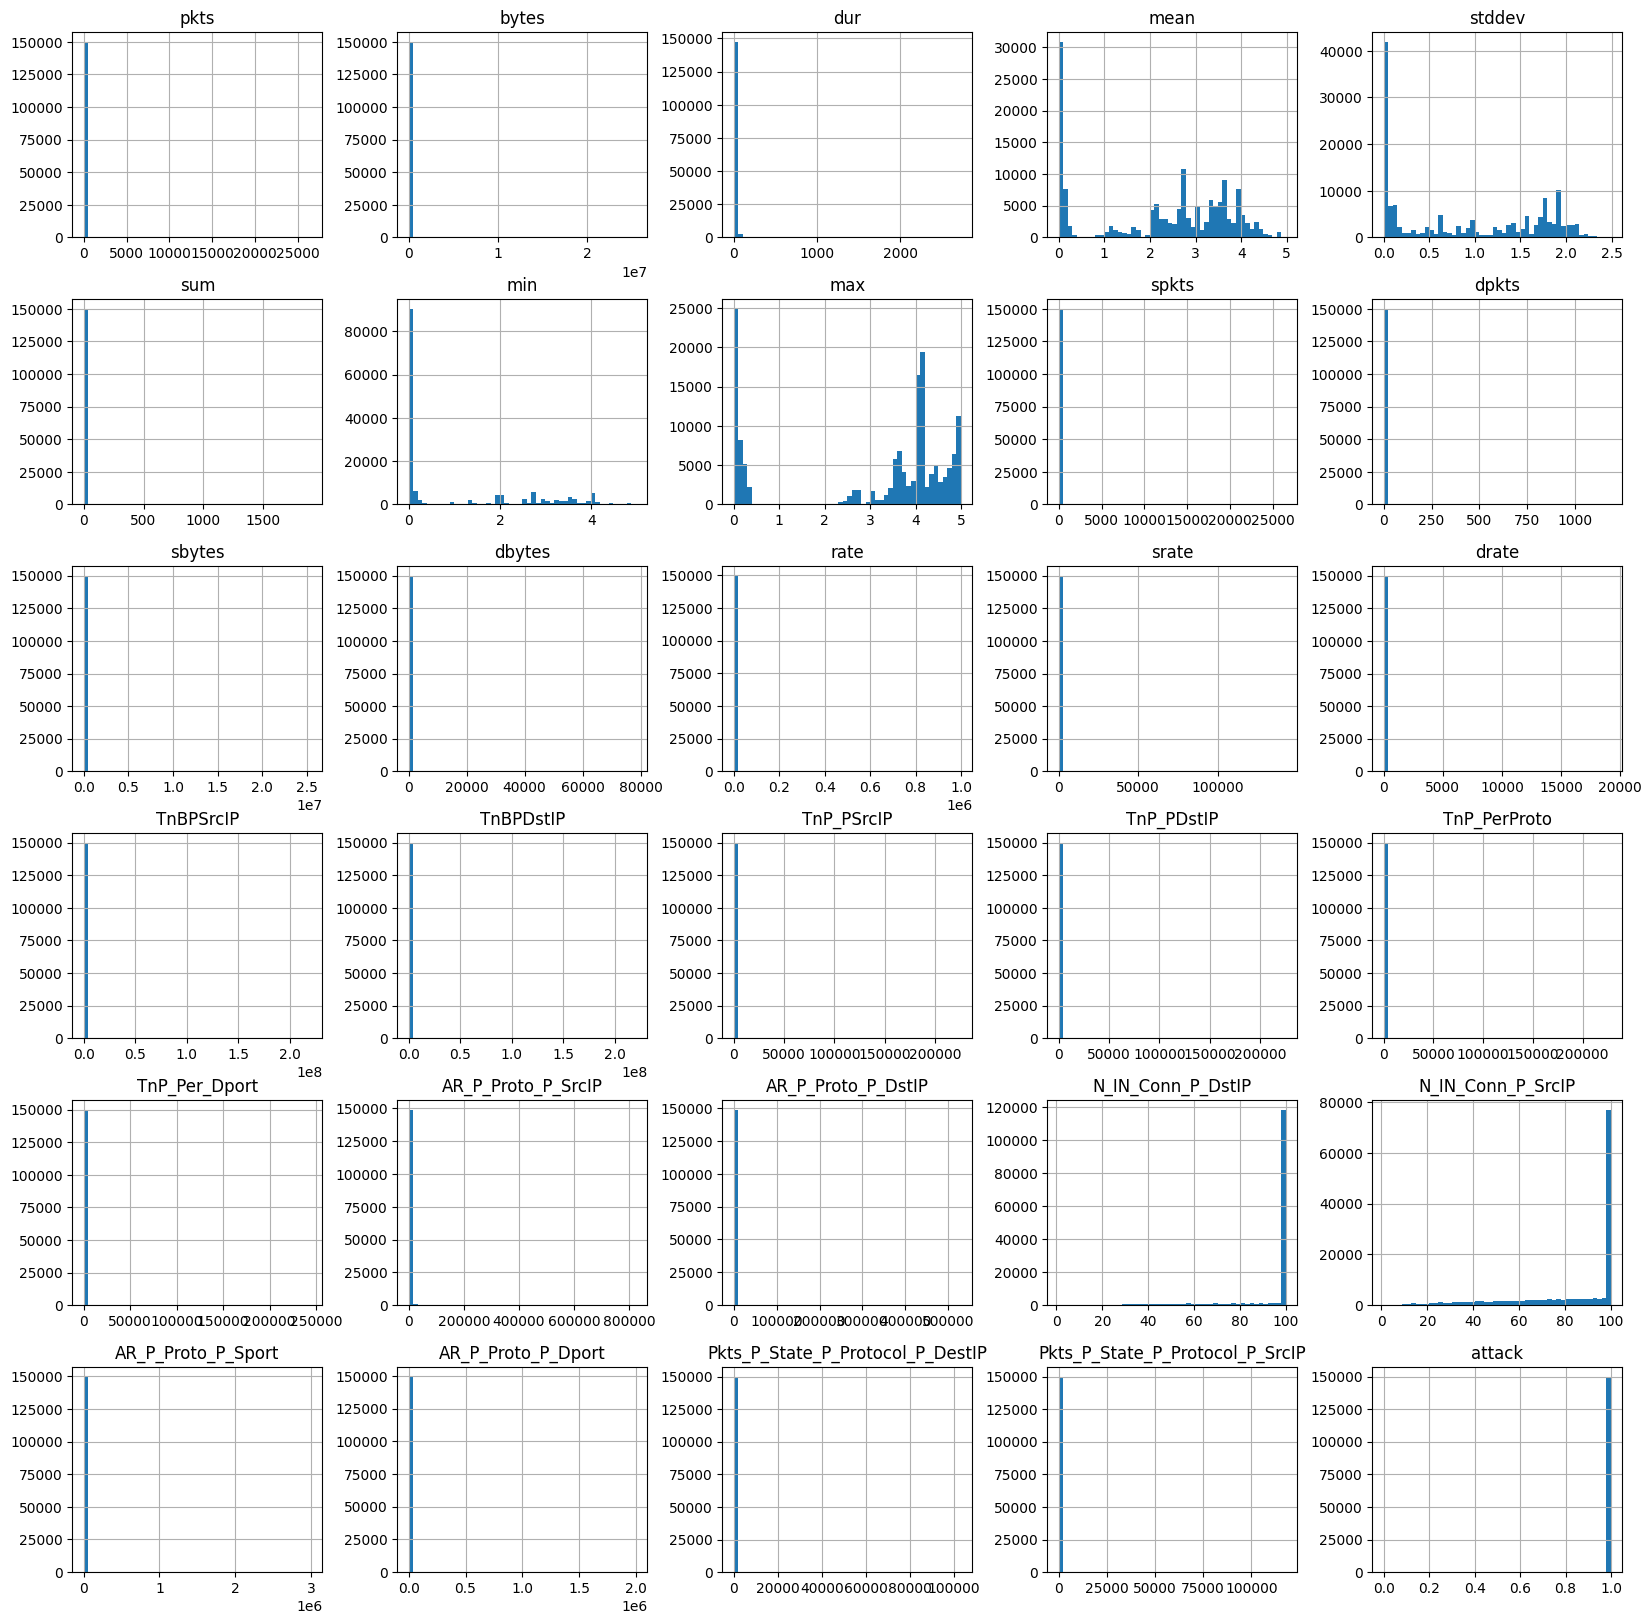

In [38]:
df.hist(figsize=(20, 20), bins=50)
plt.show()

**PIE CHART**

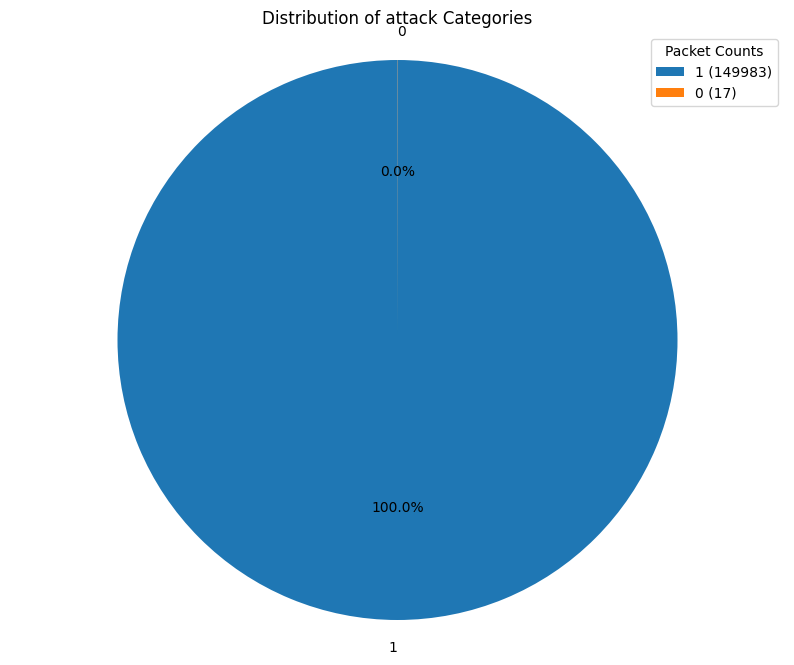

In [39]:



attack_counts = df['attack'].value_counts()

plt.figure(figsize=(10, 8))
plt.pie(attack_counts, labels=attack_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of attack Categories')
plt.axis('equal')
legend_labels = [f'{label} ({count})' for label, count in zip(attack_counts.index, attack_counts.values)]
plt.legend(legend_labels, title="Packet Counts", loc="best")
plt.show()


**BOX PLOT**

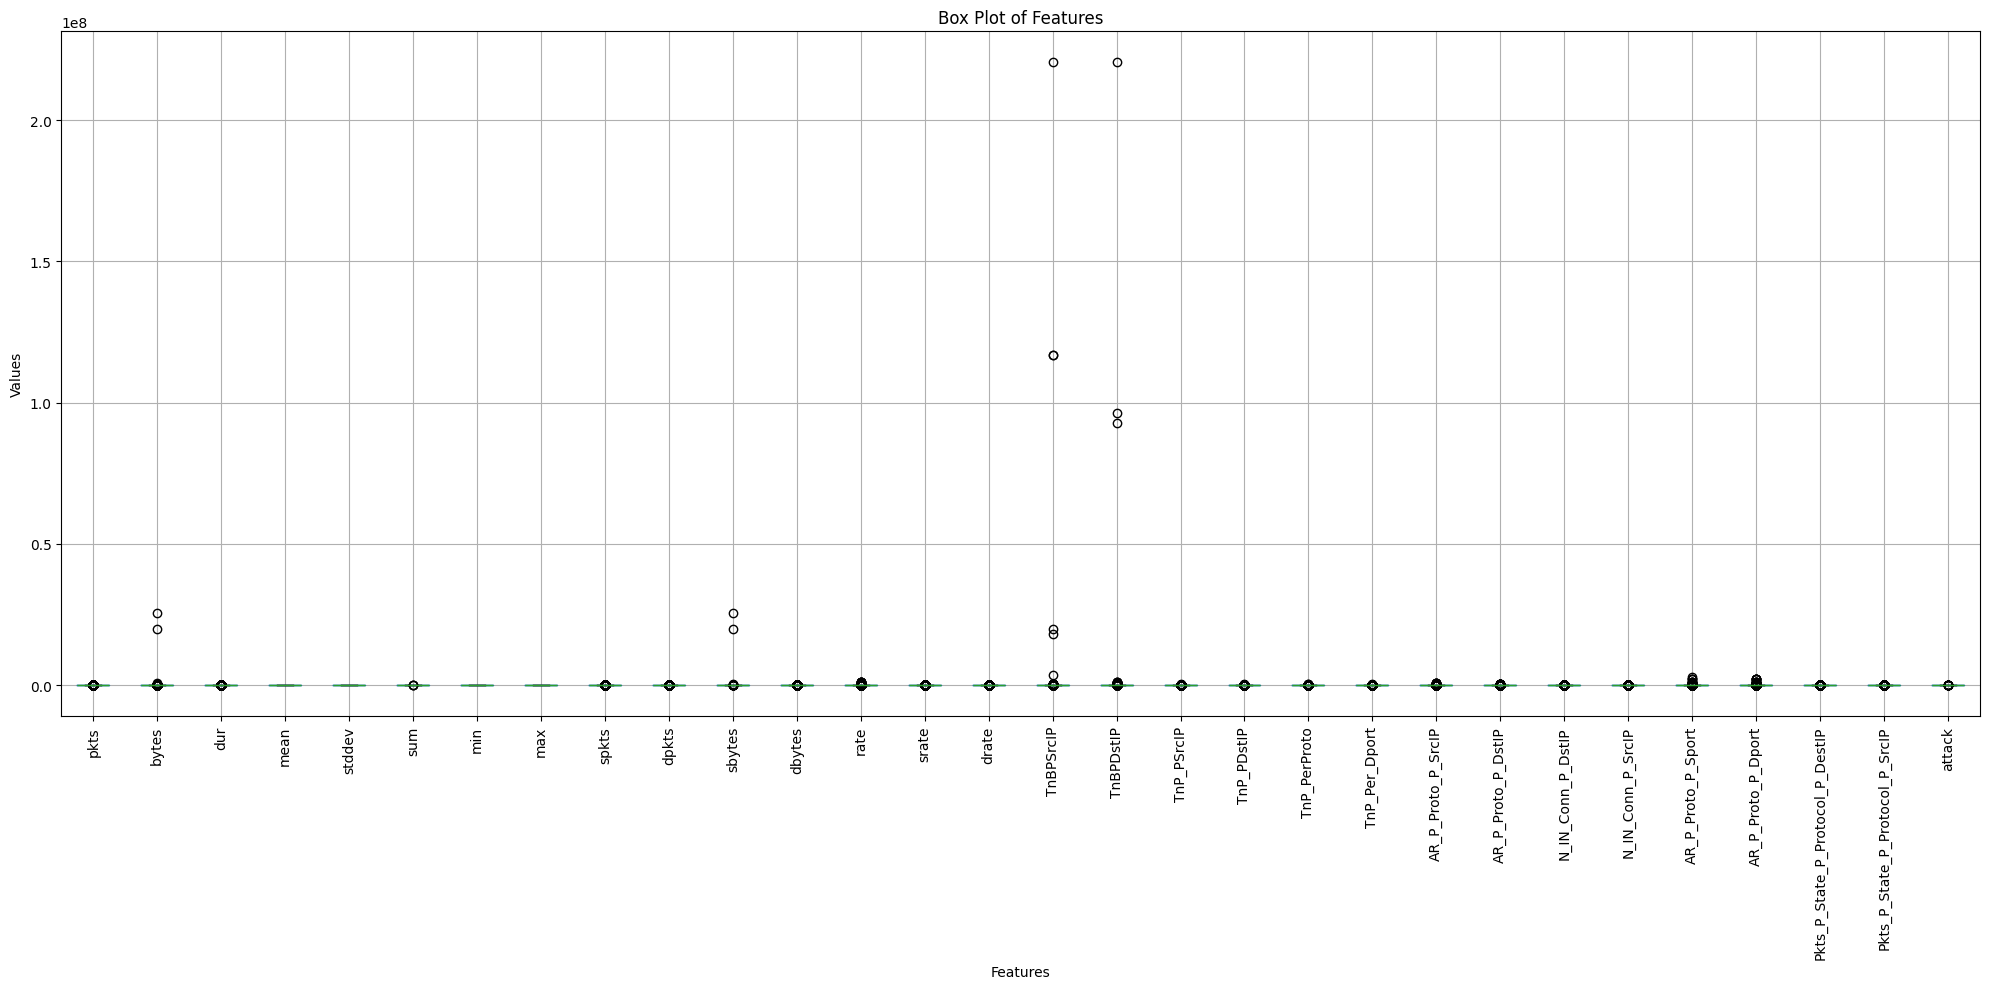

In [40]:
plt.figure(figsize=(20, 10))
df.boxplot(rot=90, widths=0.5)
plt.title('Box Plot of Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.tight_layout()
plt.show()


we can see from the box plot that the there are a few outliers present so we can remove these outliers by using z-score method

# **Z-SCORE OUTLIER REMOVAL**

In [41]:
import pandas as pd
import numpy as np
from scipy import stats

def remove_outliers_zscore_attack_data(data, threshold=4):
    original_rows = data.shape[0]
    normal_data = data[data['attack'] == 0]
    attack_data = data[data['attack'] == 1]

    # Apply Z-score only on numeric features
    numeric_cols = attack_data.select_dtypes(include=['number']).columns

    # Create a mask for inliers
    inlier_mask = pd.Series(True, index=attack_data.index)
    outlier_count_by_feature = {}

    print(f"Applying Z-score with threshold {threshold} on {len(numeric_cols)} numeric features...")

    # Apply Z-score to each numeric column
    for col in numeric_cols:
        if col not in ['attack']:  # Skip target variables
            # Calculate Z-scores
            z_scores = np.abs(stats.zscore(attack_data[col], nan_policy='omit'))

            # Count outliers in this feature
            feature_outliers = (z_scores > threshold).sum()
            outlier_count_by_feature[col] = feature_outliers

            # Update mask - keep only rows where Z-score is below threshold
            col_mask = z_scores <= threshold
            inlier_mask = inlier_mask & col_mask

    # Extract attack data without outliers
    cleaned_attack_data = attack_data[inlier_mask]

    # Combine with normal data
    cleaned_data = pd.concat([normal_data, cleaned_attack_data])

    # Generate summary
    removed_rows = original_rows - cleaned_data.shape[0]
    percent_removed = (removed_rows / original_rows) * 100

    print(f"Outlier removal summary:")
    print(f"  - Original dataset: {original_rows} rows")
    print(f"  - Outliers removed: {removed_rows} rows ({percent_removed:.2f}%)")
    print(f"  - Final dataset: {cleaned_data.shape[0]} rows")

    # Display features with most outliers
    print("\nFeatures with most outliers:")
    outlier_df = pd.DataFrame({
        'Feature': outlier_count_by_feature.keys(),
        'Outlier Count': outlier_count_by_feature.values()
    }).sort_values('Outlier Count', ascending=False).head(10)
    print(outlier_df)

    return cleaned_data

# Example usage
df = remove_outliers_zscore_attack_data(df, threshold=3)

Applying Z-score with threshold 3 on 30 numeric features...
Outlier removal summary:
  - Original dataset: 150000 rows
  - Outliers removed: 8921 rows (5.95%)
  - Final dataset: 141079 rows

Features with most outliers:
               Feature  Outlier Count
23   N_IN_Conn_P_DstIP           5253
9                dpkts           2070
22  AR_P_Proto_P_DstIP           1030
21  AR_P_Proto_P_SrcIP            827
24   N_IN_Conn_P_SrcIP            703
12                rate            315
26  AR_P_Proto_P_Dport            292
25  AR_P_Proto_P_Sport            288
17          TnP_PSrcIP            186
18          TnP_PDstIP            183


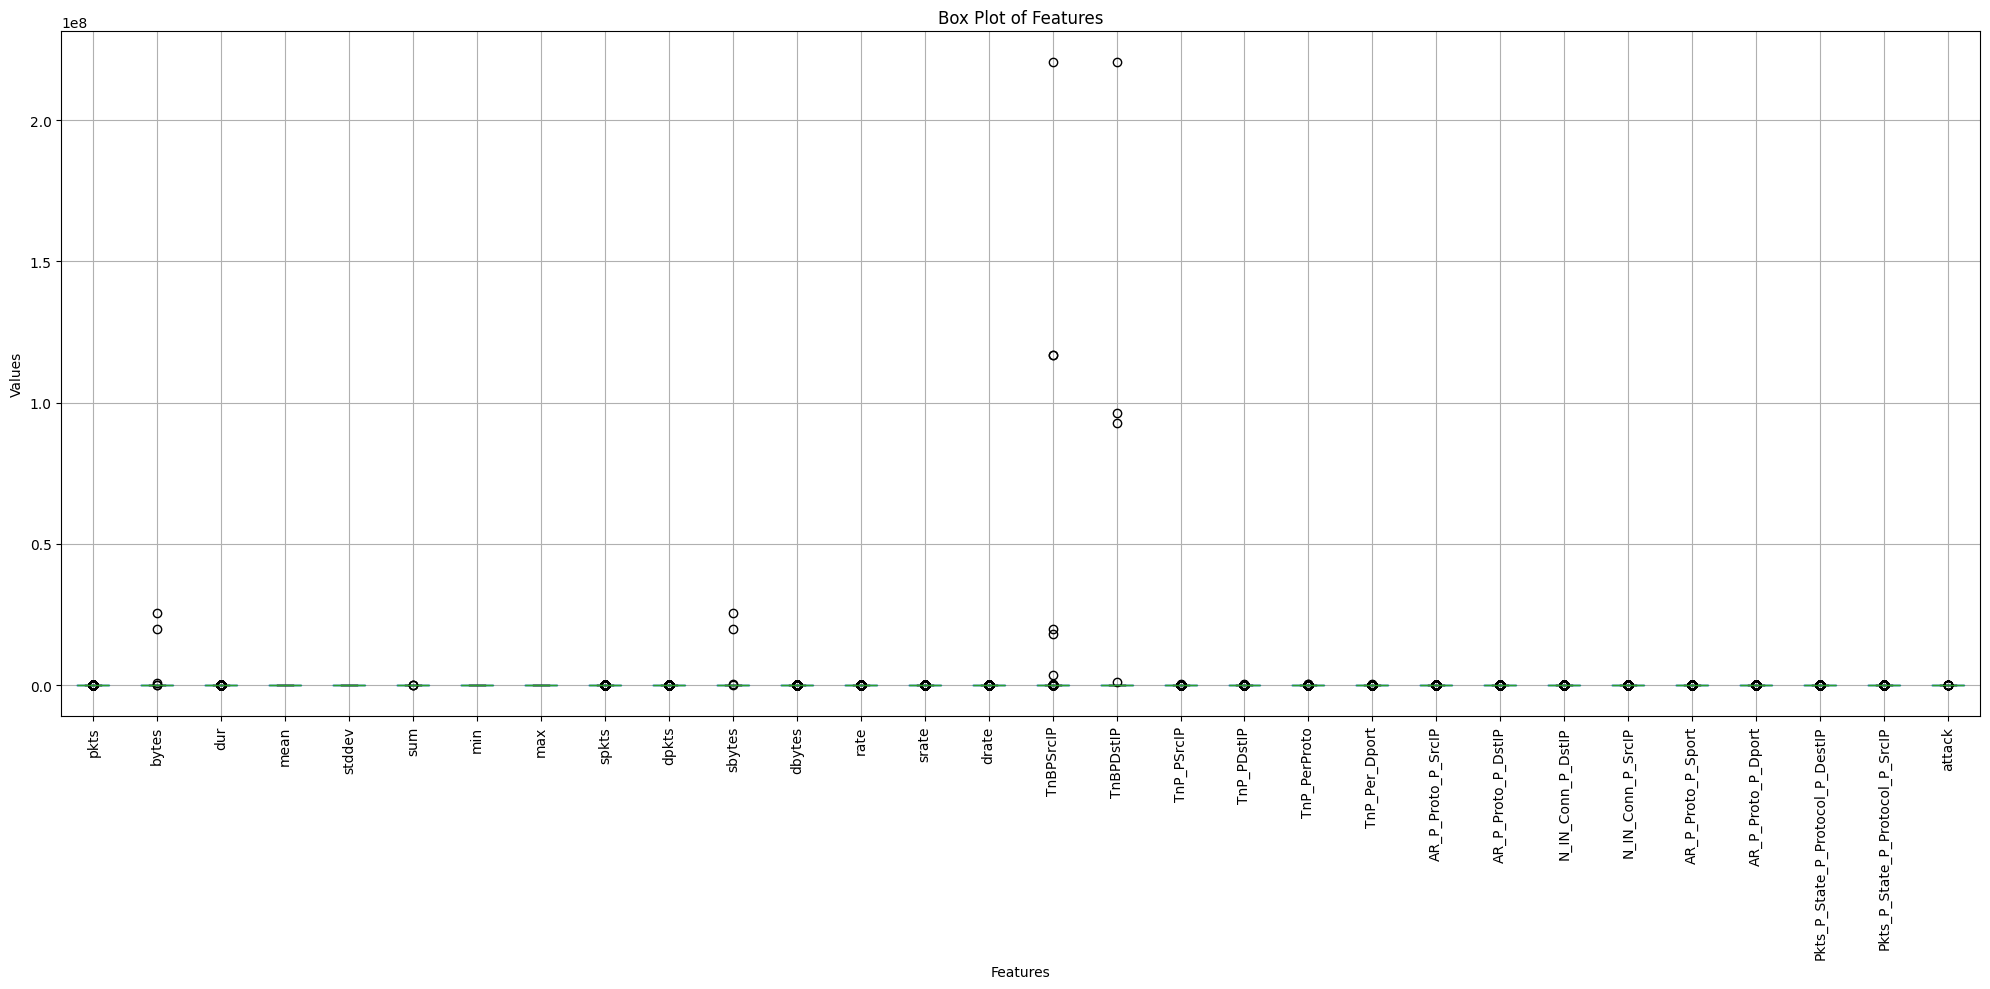

In [42]:
plt.figure(figsize=(20, 10))
df.boxplot(rot=90, widths=0.5)
plt.title('Box Plot of Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

In [43]:
df['attack'].value_counts()

,count
attack,
1,141062
0,17


In [44]:
df.reset_index(drop=True)

,pkts,bytes,dur,mean,stddev,sum,min,max,spkts,dpkts,...,TnP_Per_Dport,AR_P_Proto_P_SrcIP,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack
0,2,120,0.000111,0.000111,0.000000,0.000111,0.000111,0.000111,1,1,...,78,29703.000000,18018.000000,1,6,0.012107,0.012107,2,12,0
1,2,1401,0.015130,0.015130,0.000000,0.015130,0.015130,0.015130,1,1,...,68,17.105100,130.621000,2,20,132.188000,3.111570,4,26,0
2,2,180,0.007474,0.007474,0.000000,0.007474,0.007474,0.007474,1,1,...,12,3.479700,267.594000,1,6,267.594000,28.321100,2,8,0
3,2,474,0.010410,0.010410,0.000000,0.010410,0.010410,0.010410,1,1,...,122,9.493260,196.358000,2,74,192.123000,9.493260,4,122,0
4,2,172,2.501129,0.000000,0.000000,0.000000,0.000000,0.000000,2,0,...,100,2.832840,0.799755,9,10,0.799639,0.083079,18,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141074,7,420,12.161448,2.706286,1.913634,8.118858,0.000000,4.062305,7,0,...,700,0.575589,0.575589,100,100,0.575589,0.575589,700,700,1
141075,11,660,24.610233,2.846478,0.532189,14.232388,2.539589,3.909683,11,0,...,1100,0.446975,0.446975,100,100,0.446969,0.446975,1100,1100,1
141076,3,274,0.178547,0.178547,0.000000,0.178547,0.178547,0.178547,2,1,...,300,15.937700,15.937700,100,100,16.802300,15.937700,300,300,1
141077,8,480,32.158215,3.298694,0.798594,13.194777,1.935859,3.975932,8,0,...,800,0.248772,0.248772,100,100,0.248770,0.248772,800,800,1


# **DIVIDING THE DATASET FOR TRAINING AND TESTING**

In [45]:
X = df.drop('attack', axis=1)
y = df['attack']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **SCALING THE DATASET**

In [46]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# **HANDLING CLASS IMBALANCE IF ANY PRESENT**

In [47]:
print("Class distribution before SMOTE:")
print(y.value_counts())


smote = SMOTE(random_state=1)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train).value_counts())

Class distribution before SMOTE:
attack
1    141062
0        17
Name: count, dtype: int64

Class distribution after SMOTE:
attack
1    112848
0    112848
Name: count, dtype: int64


# **WHAT IS FEATURE SELECTION**



Features in machine learning, also known as variables or attributes, are individual measurable properties or characteristics of the phenomena being observed. They serve as the input to the model, and their quality and quantity can greatly influence the accuracy and efficiency of the model.



**FEATURE IMPORTANCE WITH RANDOM FOREST**

Feature Ranking:
1. N_IN_Conn_P_DstIP: 0.2116453276748929
2. AR_P_Proto_P_SrcIP: 0.14271763316827266
3. TnP_Per_Dport: 0.11768614500097857
4. N_IN_Conn_P_SrcIP: 0.10768899345612834
5. TnP_PerProto: 0.09228631232260696
6. TnP_PDstIP: 0.09190392128856313
7. TnBPDstIP: 0.0466813663182647
8. bytes: 0.036992362113833596
9. Pkts_P_State_P_Protocol_P_DestIP: 0.024073867939244237
10. dbytes: 0.015035794688814653
11. rate: 0.013573566762186441
12. TnBPSrcIP: 0.013335377455280982
13. TnP_PSrcIP: 0.013252672501950637
14. AR_P_Proto_P_Sport: 0.011793962038301742
15. AR_P_Proto_P_Dport: 0.011042094797092736
16. spkts: 0.010761307260478772
17. sbytes: 0.010091202425533519
18. sum: 0.0061899389237670245
19. stddev: 0.005647068724035247
20. pkts: 0.005284320405095515
21. dur: 0.004377256260810355
22. Pkts_P_State_P_Protocol_P_SrcIP: 0.004351738983901053
23. AR_P_Proto_P_DstIP: 0.0028759851437781124
24. srate: 0.0004915991790837303
25. dpkts: 0.00017440548549172102
26. max: 2.9489288825100218e-05
27. m

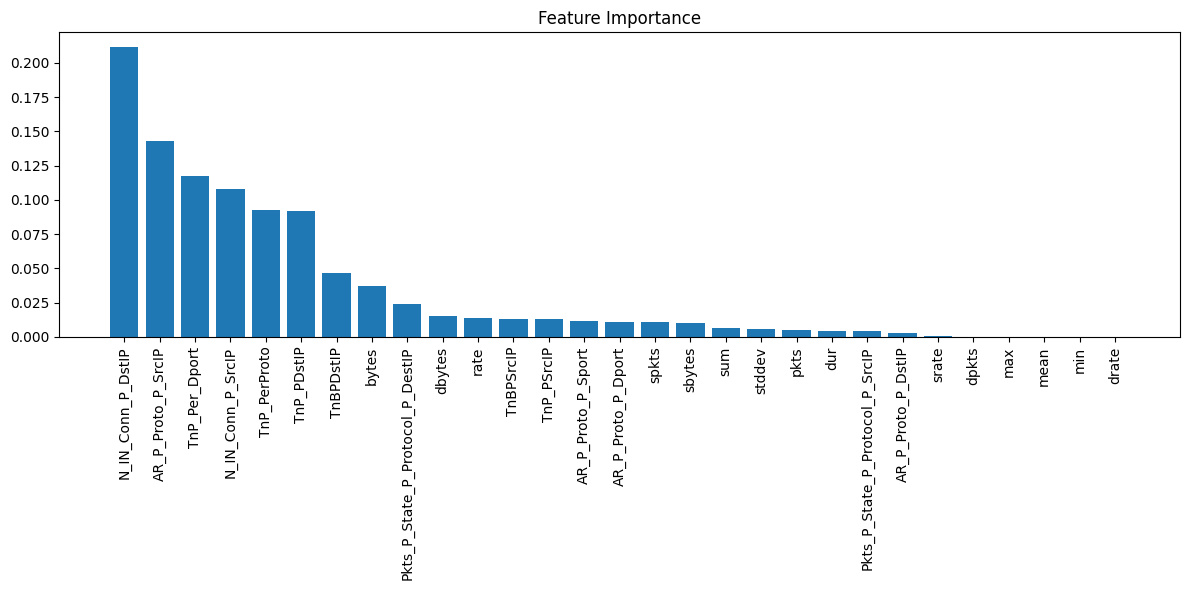

In [48]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort feature indices in descending order of importance
feature_names = X.columns  # Get feature names

# 6. Print Feature Ranking
print("Feature Ranking:")
for i in range(X.shape[1]):
    print(f"{i + 1}. {feature_names[indices[i]]}: {importances[indices[i]]}")

# 7. Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [49]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

top_10_indices = indices[:10]
top_10_features = [feature_names[i] for i in top_10_indices]

X_selected = X[top_10_features]

X_selected



,N_IN_Conn_P_DstIP,AR_P_Proto_P_SrcIP,TnP_Per_Dport,N_IN_Conn_P_SrcIP,TnP_PerProto,TnP_PDstIP,TnBPDstIP,bytes,Pkts_P_State_P_Protocol_P_DestIP,dbytes
13208,1,29703.000000,78,6,78,2,120,120,2,60
39731,2,17.105100,68,20,200009,4,2702,1401,4,1331
43481,1,3.479700,12,6,124664,2,180,180,2,90
48539,2,9.493260,122,74,142,4,960,474,4,380
51917,9,2.832840,100,10,124664,18,1548,172,18,0
...,...,...,...,...,...,...,...,...,...,...
149995,100,0.575589,700,100,700,700,42000,420,700,0
149996,100,0.446975,1100,100,1100,1100,66000,660,1100,0
149997,100,15.937700,300,100,300,300,27400,274,300,60
149998,100,0.248772,800,100,800,800,48000,480,800,0


In [50]:
from sklearn.linear_model import LogisticRegression
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(X_selected, y, test_size=0.2)


model = LogisticRegression(max_iter=100000)
model.fit(X_train_LR, y_train_LR)

y_pred_LR = model.predict(X_test_LR)
accuracy = accuracy_score(y_test_LR, y_pred_LR)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9999645591153955


**FILTER FEATURE SELECTION METHOD**



**PEARSONS CORRELATION COEFFICIENT**

Correlation coefficients are used to measure how strong a relationship is between two variables. There are different types of formulas to get a correlation coefficient, one of the most popular is Pearson’s correlation (also known as Pearson’s r) which is commonly used for linear regression.

r = n(∑xy) – (∑x)(∑y) / √[n∑x²-(∑x)²][n∑y²-(∑y)²

In [51]:
from scipy import stats

correlation_matrix = df.corr()
correlation_threshold = 0.1
target_variable = 'attack'

correlated_features = []
p_values = []

for feature in correlation_matrix.columns:
    if feature != target_variable:
        correlation = correlation_matrix.loc[feature, target_variable]
        if abs(correlation) > correlation_threshold:

            _, p_value = stats.pearsonr(df[feature], df[target_variable])
            correlated_features.append(feature)
            p_values.append(p_value)


results_df = pd.DataFrame({'feature': correlated_features, 'correlation': correlation_matrix[target_variable][correlated_features].values, 'p_value': p_values})

print("Selected features with p-values:")
print(results_df)

selected_features_df = df[correlated_features]

selected_features_df

Selected features with p-values:
                             feature  correlation  p_value
0                               pkts    -0.356541      0.0
1                              bytes    -0.344641      0.0
2                                dur    -0.265457      0.0
3                                sum    -0.313963      0.0
4                              spkts    -0.348506      0.0
5                              dpkts    -0.244629      0.0
6                             sbytes    -0.343979      0.0
7                             dbytes    -0.272186      0.0
8                          TnBPSrcIP    -0.433824      0.0
9                          TnBPDstIP    -0.385385      0.0
10                        TnP_PSrcIP    -0.393475      0.0
11                        TnP_PDstIP    -0.359461      0.0
12                      TnP_PerProto    -0.805604      0.0
13                     TnP_Per_Dport    -0.226234      0.0
14  Pkts_P_State_P_Protocol_P_DestIP    -0.292290      0.0
15   Pkts_P_State_P_Pro

,pkts,bytes,dur,sum,spkts,dpkts,sbytes,dbytes,TnBPSrcIP,TnBPDstIP,TnP_PSrcIP,TnP_PDstIP,TnP_PerProto,TnP_Per_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP
13208,2,120,0.000111,0.000111,1,1,60,60,702,120,12,2,78,78,2,12
39731,2,1401,0.015130,0.015130,1,1,70,1331,116736097,2702,118038,4,200009,68,4,26
43481,2,180,0.007474,0.007474,1,1,90,90,18854,180,41,2,124664,12,2,8
48539,2,474,0.010410,0.010410,1,1,94,380,48697,960,190,4,142,122,4,122
51917,2,172,2.501129,0.000000,2,0,172,0,31525,1548,86,18,124664,100,18,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,7,420,12.161448,8.118858,7,0,420,0,42000,42000,700,700,700,700,700,700
149996,11,660,24.610233,14.232388,11,0,660,0,66000,66000,1100,1100,1100,1100,1100,1100
149997,3,274,0.178547,0.178547,2,1,214,60,27400,27400,300,300,300,300,300,300
149998,8,480,32.158215,13.194777,8,0,480,0,48000,48000,800,800,800,800,800,800


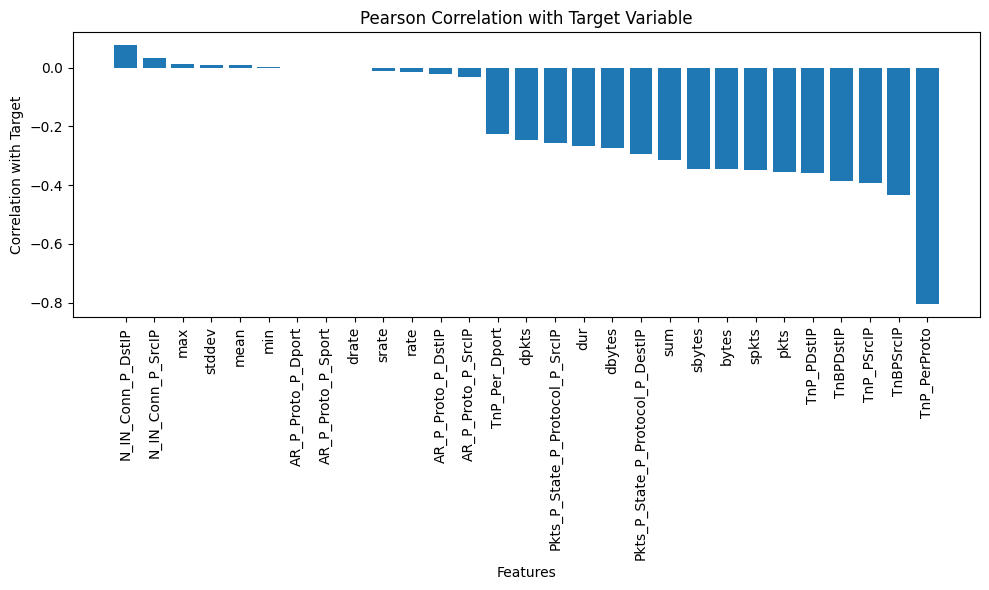

In [52]:
target_correlations = correlation_matrix['attack']


target_correlations = target_correlations.drop('attack')


target_correlations = target_correlations.sort_values(ascending=False)


plt.figure(figsize=(10, 6))
plt.bar(target_correlations.index, target_correlations.values)
plt.xlabel('Features')
plt.ylabel('Correlation with Target')
plt.title('Pearson Correlation with Target Variable')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

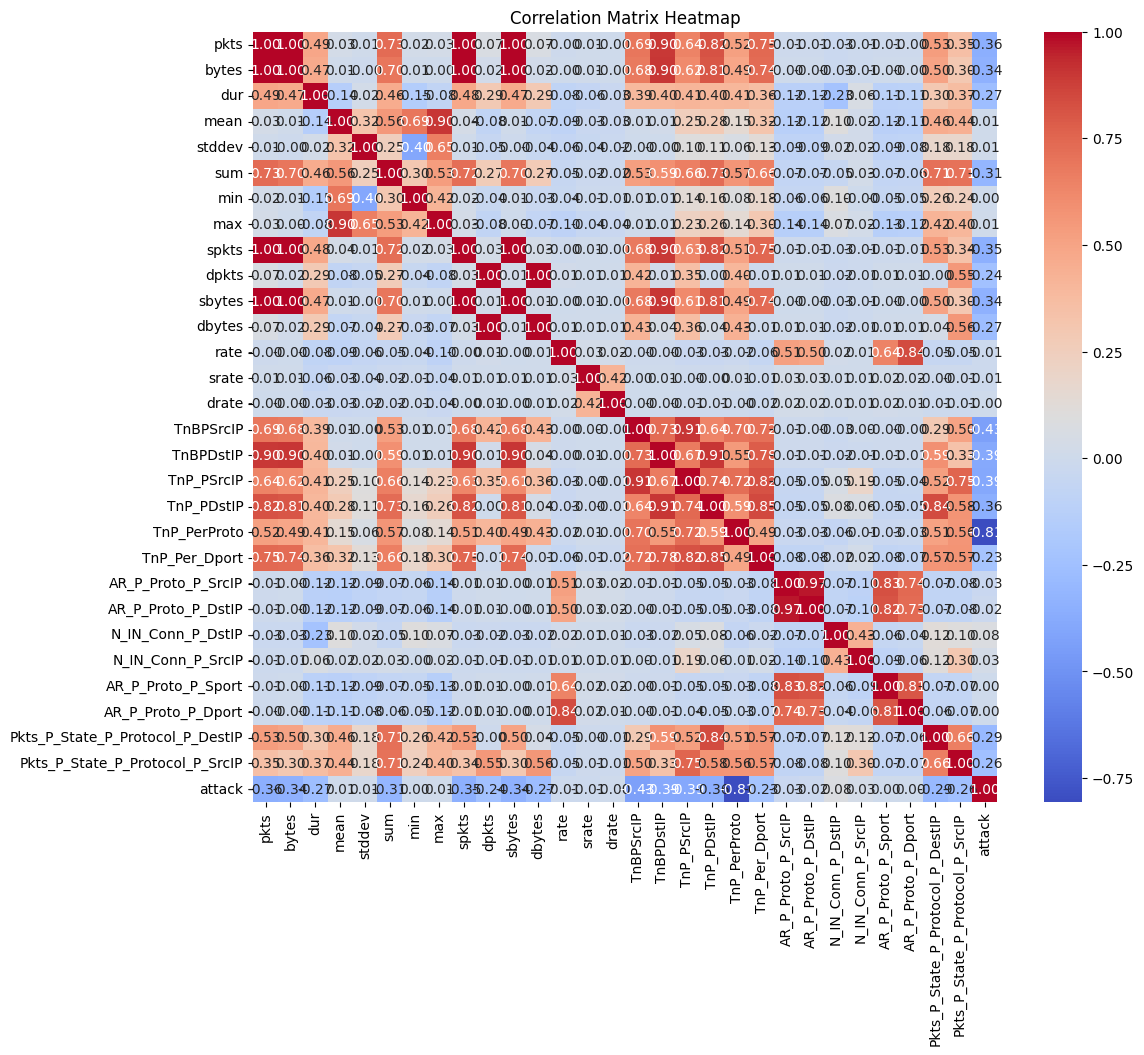

In [64]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


In [53]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(selected_features_df, y, test_size=0.2)


model = LogisticRegression(max_iter=100000)
model.fit(X_train_p, y_train_p)

y_pred_p = model.predict(X_test_p)
accuracy = accuracy_score(y_test_p, y_pred_p)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


**WRAPPER FEATURE FEATURE SELECTION METHOD**

Wrapper methods are also referred as greedy algorithms that train algorithm. They use different combination of features and compute relation between these subset features and target variable and based on conclusion addition and removal of features are done. Stopping criteria for selecting the best subset are usually pre-defined by the person training the model such as when the performance of the model decreases or a specific number of features are achieved.

**Recursive elimination**

This greedy optimization method selects features by recursively considering the smaller and smaller set of features. The estimator is trained on an initial set of features and their importance is obtained using feature_importance_attribute. The least important features are then removed from the current set of features till we are left with the required number of features.

In [54]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(max_iter=10000)
rfe = RFE(estimator=model, n_features_to_select=5)
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]

X_selected = X[selected_features]

X_selected

,pkts,dur,spkts,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP
13208,2,0.000111,1,1,6
39731,2,0.015130,1,2,20
43481,2,0.007474,1,1,6
48539,2,0.010410,1,2,74
51917,2,2.501129,2,9,10
...,...,...,...,...,...
149995,7,12.161448,7,100,100
149996,11,24.610233,11,100,100
149997,3,0.178547,2,100,100
149998,8,32.158215,8,100,100


In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train_selected, X_test_selected, y_train_rfe, y_test_rfe = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train_selected, y_train_rfe)

y_pred_rfe = tree_model.predict(X_test_selected)

# Print Results:
print("Accuracy:", accuracy_score(y_test_rfe, y_pred_rfe))
print("\nClassification Report:\n", classification_report(y_test_rfe, y_pred_rfe))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_rfe, y_pred_rfe))

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00     28214

    accuracy                           1.00     28216
   macro avg       1.00      1.00      1.00     28216
weighted avg       1.00      1.00      1.00     28216


Confusion Matrix:
 [[    2     0]
 [    0 28214]]


**HYBRID FEATURE SELECTION**

where we use both filter and wrapper method to select best features of our dataset and the results would be more accurate

In [56]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def hybrid_feature_selection(X, y, filter_k=20, final_k=10):

    print(f"Starting hybrid feature selection (Filter + Wrapper)")
    print(f"Filter stage will select top {filter_k} features")
    print(f"Wrapper stage will select final {final_k} features")

    print("\nStage 1: Applying mutual information filter...")
    filter_selector = SelectKBest(mutual_info_classif, k=filter_k)
    X_filter = filter_selector.fit_transform(X_train, y_train)

    filter_mask = filter_selector.get_support()
    if feature_names is not None:
        filter_features = [feature_names[i] for i in range(len(feature_names)) if filter_mask[i]]
    else:
        try:
            filter_features = X.columns[filter_mask].tolist()
        except AttributeError:
            raise AttributeError("Input X must be a DataFrame or provide feature_names")

    X_train_filtered = pd.DataFrame(X_filter, columns=filter_features)
    X_test_filtered = pd.DataFrame(
        filter_selector.transform(X_test),
        columns=filter_features
    )

    print(f"Filter stage selected {len(filter_features)} features")

    print("\nStage 2: Applying RFE wrapper method...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rfe = RFE(estimator=rf, n_features_to_select=final_k, step=1)

    rfe.fit(X_train_filtered, y_train)

    final_mask = rfe.support_
    final_features = np.array(filter_features)[final_mask].tolist()

    X_train_final = rfe.transform(X_train_filtered)
    X_test_final = rfe.transform(X_test_filtered)

    rf.fit(X_train_final, y_train)
    y_pred = rf.predict(X_test_final)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Final selection: {len(final_features)} features")
    print(f"Model accuracy with selected features: {accuracy:.4f}")
    print(f"\nSelected features: {final_features}")

    importances = pd.Series(rfe.estimator_.feature_importances_, index=np.array(filter_features)[final_mask])

hybrid_feature_selection(X_train,y_train)

Starting hybrid feature selection (Filter + Wrapper)
Filter stage will select top 20 features
Wrapper stage will select final 10 features

Stage 1: Applying mutual information filter...
Filter stage selected 20 features

Stage 2: Applying RFE wrapper method...
Final selection: 10 features
Model accuracy with selected features: 1.0000

Selected features: ['bytes', 'sbytes', 'TnBPDstIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'Pkts_P_State_P_Protocol_P_DestIP']


**BAGGING**

Bagging is an ensemble learning technique designed to reduce variance and improve the stability and accuracy of machine learning models.

In [57]:
from sklearn.ensemble import BaggingClassifier



# Initialize the base estimator (e.g., DecisionTreeClassifier)
base_estimator = DecisionTreeClassifier(random_state=42)

# Create the BaggingClassifier
bagging_model = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=10,  # Number of base estimators (trees)
    random_state=42
)

# Train the bagging model
bagging_model.fit(X_train, y_train)

# Make predictions
y_pred_bagging = bagging_model.predict(X_test)

# Evaluate the model
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
print(f"Bagging Accuracy: {accuracy_bagging}")
print("\nClassification Report (Bagging):\n", classification_report(y_test, y_pred_bagging, zero_division=0))
print("\nConfusion Matrix (Bagging):\n", confusion_matrix(y_test, y_pred_bagging))

Bagging Accuracy: 1.0

Classification Report (Bagging):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00     28214

    accuracy                           1.00     28216
   macro avg       1.00      1.00      1.00     28216
weighted avg       1.00      1.00      1.00     28216


Confusion Matrix (Bagging):
 [[    2     0]
 [    0 28214]]


**BOOSTING**

Boosting is an ensemble learning technique that combines multiple weak learners (models that perform slightly better than random guessing) to create a strong learner.



In [58]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42)

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb}")

# Print classification report
print("\nClassification Report (XGBoost):\n", classification_report(y_test, y_pred_xgb, zero_division=0))

# Print confusion matrix
print("\nConfusion Matrix (XGBoost):\n", confusion_matrix(y_test, y_pred_xgb))


XGBoost Accuracy: 1.0

Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00     28214

    accuracy                           1.00     28216
   macro avg       1.00      1.00      1.00     28216
weighted avg       1.00      1.00      1.00     28216


Confusion Matrix (XGBoost):
 [[    2     0]
 [    0 28214]]


**STACKING**

Stacking is an ensemble learning technique that combines multiple models (called base learners) by using another model (called a meta-learner) to make the final prediction.

In [59]:
# prompt: now perform stacking as you did for boosting

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define the base learners
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBClassifier(random_state=42)),
    ('bagging', bagging_model)
]

# Define the meta-learner
final_estimator = LogisticRegression()

# Create the stacking classifier
stacking_model = StackingClassifier(estimators=estimators, final_estimator=final_estimator)


# Train the stacking model
stacking_model.fit(X_train, y_train)

# Make predictions
y_pred_stacking = stacking_model.predict(X_test)

# Evaluate the model
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
print(f"Stacking Accuracy: {accuracy_stacking}")

# Print classification report
print("\nClassification Report (Stacking):\n", classification_report(y_test, y_pred_stacking, zero_division=0))

# Print confusion matrix
print("\nConfusion Matrix (Stacking):\n", confusion_matrix(y_test, y_pred_stacking))


Stacking Accuracy: 1.0

Classification Report (Stacking):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00     28214

    accuracy                           1.00     28216
   macro avg       1.00      1.00      1.00     28216
weighted avg       1.00      1.00      1.00     28216


Confusion Matrix (Stacking):
 [[    2     0]
 [    0 28214]]


In [60]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_leaf=5,
    random_state=42
)

In [62]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)

# Print the mean and standard deviation of the scores
print("Mean Accuracy:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())


Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean Accuracy: 1.0
Standard Deviation: 0.0


**NEURAL NETWORKS**

In [66]:


import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Assuming X and y are already defined from the previous code
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train_nn.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train_nn, y_train_nn, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_nn, y_test_nn)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2822/2822 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9819 - loss: 1047.4325 - val_accuracy: 0.9943 - val_loss: 165.7879
Epoch 2/10
2822/2822 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9770 - loss: 649.3095 - val_accuracy: 0.9912 - val_loss: 9.8890
Epoch 3/10
2822/2822 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9976 - loss: 21.9257 - val_accuracy: 1.0000 - val_loss: 0.6768
Epoch 4/10
2822/2822 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9897 - loss: 203.0011 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
2822/2822 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
2822/2822 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
2822/2822 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
2822/2822 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accu